### Setting up GPU memory growth to avoid OOM errors

In [1]:
import tensorflow as tf

# avoid oom errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Hyperparameters

In [2]:
# hyperparameter for contrastive loss
margin = 1

# hyperparameter for few-shot learning
learning_rate = .001 # initial learning rate
meta_step_size = .25 # current learning rate

inner_batch_size = 32 # same to batch_size
eval_batch_size = 32 # same to batch_size

meta_iters = 1000 # same to epoch
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20 # total image needed per class for training
shots = 5 # total image needed per class for validation
classes = 10 # total class

### Data Loader

In [3]:
class DataLoader:
    """Facilitate the creation of few-shot dataset.
    
    Argument:
        training: Boolean, telling wether dataset is used for training or testing
    """
    
    def __init__(self, training):
        split = 'train' if training else 'test'
        ds = tfds.load('mnist', split=split, as_supervised=True, shuffle_files=False)
        self.data = {}
    
        def extract(image, label):
            """Preprocess the dataset.
            
            Argument:
                image: vector containing image array
                label: vector containing label array
            
            Return:
                image: preprocessed vector containing image array
                label: vector containing label array
            """
            
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, [28,28])
            return image, label
        
        for image, label in ds.map(extract):
            image = image.numpy()
            label = str(label.numpy())
            
            # check if label exist in self.data, if not exist create new keys
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())
    
    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):
        """Create mini batch dataset for few-shot learning
        
        Argument:
            batch_size: total images passed in 1 batch
            repetitions: total iterations in evaluation
            shots: total of image will be trained
            num_classes: total classes
        
        Return:
            dataset: tensorflow.Dataset containing image and label
        """
        
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))
        
        # get random subset of label
        label_subset = random.choices(self.labels, k=num_classes)
        for idx, label in enumerate(label_subset):
            # use enumerated index value as temporary label for mini-batch
            temp_labels[idx * shots:(idx + 1) * shots] = idx
            
            # if creating split dataset for testing, select extra sample from each label
            if split:
                test_labels[idx] = idx
                images_to_split = random.choices(self.data[label_subset[idx]], k=shots + 1)
                test_images[idx] = images_to_split[-1]
                temp_images[idx * shots:(idx + 1) * shots] = images_to_split[:-1]
            else:
                # randomly select label_subset
                temp_images[idx * shots:(idx + 1) * shots] = random.choices(self.data[label_subset[idx]], k=shots)
        
        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [4]:
import numpy as np
import random
import tensorflow_datasets as tfds
import urllib3

urllib3.disable_warnings()
train_ds = DataLoader(training=True)
test_ds = DataLoader(training=False)

### Visualize the Data

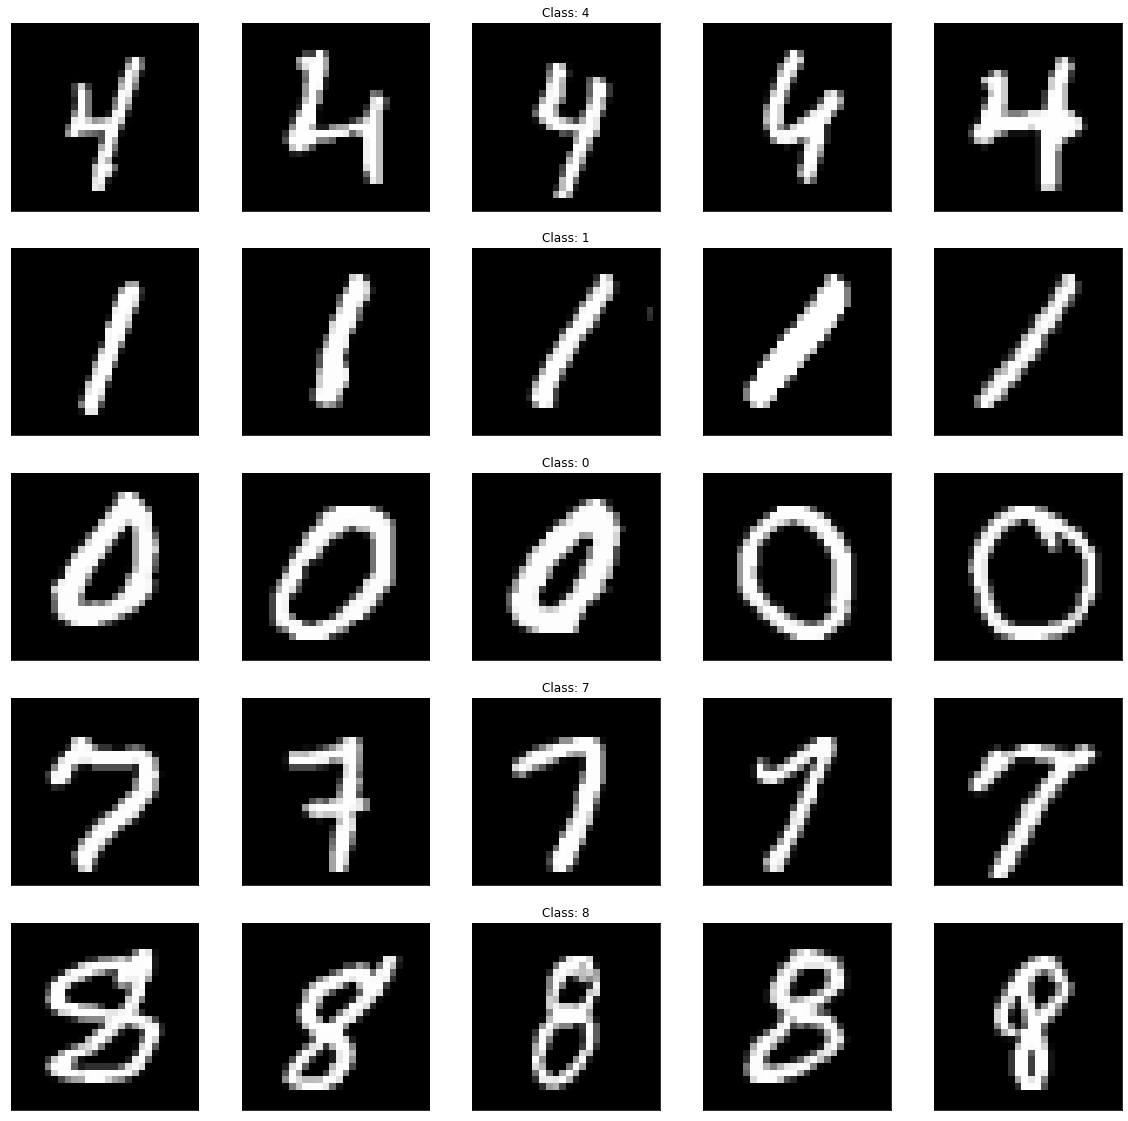

In [5]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(5,5, figsize=(20,20))
sample_keys = list(train_ds.data.keys())

for i in range(5):
    for j in range(5):
        temp_image = train_ds.data[sample_keys[i]][j]
        temp_image = np.stack((temp_image[:,:,0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype('uint8')
        if j == 2:
            axs[i,j].set_title('Class: ' + sample_keys[i])
        axs[i,j].imshow(temp_image, cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
plt.show()

### Splitting Data

In [6]:
train = train_ds.get_mini_dataset(inner_batch_size, inner_iters, train_shots, classes)

In [7]:
def tensor_to_array(train):
    train_images, train_labels = [], []
    for images, labels in train:
        for image in images:
            train_images.append(image.numpy())

        for label in labels:
            train_labels.append(label.numpy())
    return np.array(train_images), np.array(train_labels)

In [8]:
train_images, train_labels = tensor_to_array(train)

In [9]:
print('Total image for training:', len(train_images))
print('Total label for training:', len(train_labels))

Total image for training: 800
Total label for training: 800


### Create Image Pair

Siamese Networks are neural networks which share weights between two or more sister networks, each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between embeddings of similar classes, resulting in embedding spaces that reflect the class segmentation of the training inputs.

We will train the model to differentiate between digits of different classes. For example, digit 0 needs to be differentiated from the rest of the digits (1 through 9), digit 1 - from 0 and 2 through 9, and so on. To carry this out, we will select N random images from class A (for example, for digit 0) and pair them with N random images from another class B (for example, for digit 1). Then, we can repeat this process for all classes of digits (until digit 9). Once we have paired digit 0 with other digits, we can repeat this process for the remaining classes for the rest of the digits (from 1 until 9).

In [10]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    
    n_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(n_classes)]
    
    pairs, labels = [], []
    for i in range(len(x)):
        # add matching example
        x1 = x[i]
        label1 = y[i]
        idx = random.choice(digit_indices[label1])
        x2 = x[idx]
        
        pairs += [[x1, x2]]
        labels += [1]
        
        # add non matching example
        label2 = random.randint(0, n_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, n_classes - 1)
        
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]
    return np.array(pairs), np.array(labels).astype('float32')

In [11]:
import numpy as np
import random

# make train pairs
pairs_train, labels_train = make_pairs(train_images, train_labels)

In [12]:
# split training pairs
X_train_1 = pairs_train[:, 0]
X_train_2 = pairs_train[:, 1]

### Visualize the Pairs and Labels

In [13]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axs = plt.subplots(num_row, num_col, figsize=(5,5))
    for i in range(to_show):
        if num_row == 1:
            ax = axs[i % num_col]
        else:
            ax = axs[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap='gray')
        ax.set_axis_off()
        if test:
            ax.set_title("Similary: {} | Distance: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Similar: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

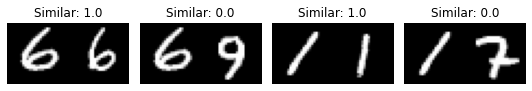

In [14]:
from matplotlib import pyplot as plt

visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

### Define the Model

There are two input layers, each leading to its own network, which produces embeddings. A Lambda layer then merges them using an Euclidean distance and the merged output is fed to the final network.

In [15]:
def euclidean_distance(vec):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vec
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [16]:
def contrastive_loss(y_true, y_pred, margin=1):
    """Calculates the constrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing constrastive loss as floating point value.
    """

    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

In [17]:
from keras import layers
from keras import Model
from tensorflow import keras

with tf.device('/GPU:0'):
    # define base model
    input = layers.Input((28,28,1))
    x = layers.BatchNormalization()(input)
    x = layers.Conv2D(4, (5,5), activation='tanh')(x)
    x = layers.AveragePooling2D(2)(x)
    x = layers.Conv2D(16, (5,5), activation='tanh')(x)
    x = layers.AveragePooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(10, activation='tanh')(x)
    model = Model(input, x)

    # define input layer for siamese network
    input_1 = layers.Input((28,28,1))
    input_2 = layers.Input((28,28,1))

    # create twins network
    model1 = model(input_1)
    model2 = model(input_2)

    # merge the 
    merge_layer = layers.Lambda(euclidean_distance)([model1, model2])
    normal_layer = layers.BatchNormalization()(merge_layer)
    output = layers.Dense(1, activation='sigmoid')(normal_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output)
    siamese.compile()

In [18]:
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           5318        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

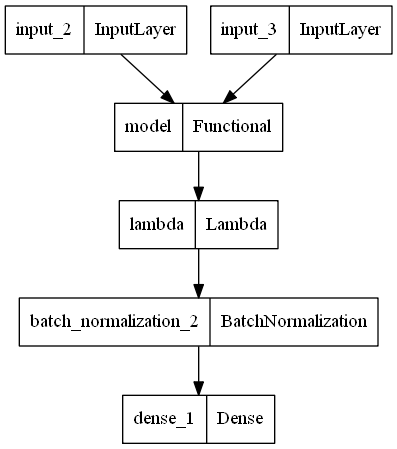

In [19]:
from keras.utils import plot_model

plot_model(siamese)

### Train the Model

In [20]:
def train_step(mini_dataset):
    """Create a custom training step
    
    Argument:
        mini_dataset: dataset from data loader contains image and labels
    
    Return:
        None
    
    """
    
    images, labels = tensor_to_array(mini_dataset)
    
    # make train pairs
    pairs_train, labels_train = make_pairs(train_images, train_labels)
    
    # split training pairs
    X_train_1 = pairs_train[:, 0]
    X_train_2 = pairs_train[:, 1]
    
    with tf.GradientTape() as tape:
        preds = siamese([X_train_1, X_train_2])
        loss = contrastive_loss(labels_train, preds, margin=margin)
    grads = tape.gradient(loss, siamese.trainable_weights)
    optimizer.apply_gradients(zip(grads, siamese.trainable_weights))

In [21]:
training = []
validation = []
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    
    # temporarily save model weiths
    old_weights = siamese.get_weights()
    
    # get sample from dataset
    mini_dataset = train_ds.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    
    train_step(mini_dataset)
    new_weights = siamese.get_weights()
    
    # perform sgd for meta step
    for weight in range(len(new_weights)):
        new_weights[weight] = old_weights[weight] + ((new_weights[weight] - old_weights[weight]) * cur_meta_step_size)
    
    # after meta learning step, reload the weight
    siamese.set_weights(new_weights)
    if meta_iter % 100 == 0:
        print('Batch %d/%d' % (meta_iter, meta_iters))

Batch 0/1000
Batch 100/1000
Batch 200/1000
Batch 300/1000
Batch 400/1000
Batch 500/1000
Batch 600/1000
Batch 700/1000
Batch 800/1000
Batch 900/1000


### Create Testing Data

In [22]:
test = test_ds.get_mini_dataset(eval_batch_size, eval_iters, shots, classes)

In [23]:
test_images, test_labels = tensor_to_array(test)

In [24]:
print('Total image for testing:', len(test_images))
print('Total label for testing:', len(test_images))

Total image for testing: 250
Total label for testing: 250


In [25]:
# make test pairs
pairs_test, labels_test = make_pairs(test_images, test_labels)

In [26]:
# split testing pairs
X_test_1 = pairs_test[:, 0]
X_test_2 = pairs_test[:, 1]

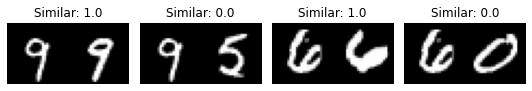

In [27]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

16/16 [==============================] - 1s 6ms/step


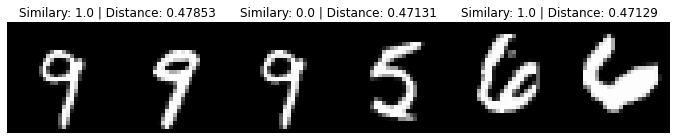

In [28]:
predictions = siamese.predict([X_test_1, X_test_2])
visualize(pairs_test, labels_test, to_show=5, predictions=predictions, test=True)